In [2]:
using Gen
using Distributions
using Random
using Plots

In [3]:
@gen function chain_particle_decay_model(T::Int, delta_t::Float64)
    lambda1 ~ gamma(3, 0.02)   # decay rate - isotope 1
    lambda2 ~ gamma(3, 0.007)  # decay rate - isotope 2
    N1_0 ~ normal(10000, 3000) # population - isotope 1

    # Initial populations and trajectories
    N1 = N1_0
    N2 = 0.0
    N1_trajectory = Float64[N1]
    N2_trajectory = Float64[N2]
    observations = Float64[]
    
    for t in 1:T
        # Expected decays at timestep t follow Poisson(lambda)
        decays1 = N1 * (1 - exp(-lambda1 * delta_t))
        decays2 = N2 * (1 - exp(-lambda2 * delta_t))       
        
        # Update populations
        N1 = max(N1 - decays1, 0.0)
        N2 = max(N2 + decays1 - decays2, 0.0)
        push!(N1_trajectory, N1)
        push!(N2_trajectory, N2)
        
        # Add the decay observation
        expected = decays1 + decays2
        obs = @trace(normal(expected, 4.0), (:obs, t)) # some noise!
        push!(observations, obs)
    end
    
    return (observations, N1_trajectory, N2_trajectory)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Float64], false, Union{Nothing, Some{Any}}[nothing, nothing], Main.var"##chain_particle_decay_model#277", Bool[0, 0], false)

In [4]:
Random.seed!(42)
T = 200        
dt = 1.0

(trace, _) = generate(chain_particle_decay_model, (T, dt))
(observations, N1_trajectory, N2_trajectory) = get_retval(trace)

println("Observed particle decay counts (every 20th):")
println(round.(observations[1:20:end], digits=2))

println("\nLatent parameters:")
println("λ1 = ", round(trace[:lambda1], digits=3))
println("λ2 = ", round(trace[:lambda2], digits=3))
println("N1(0) = ", round(trace[:N1_0], digits=0), " atoms")

Observed particle decay counts (every 20th):
[631.65, 174.93, 76.96, 52.69, 44.47, 34.26, 26.12, 25.52, 17.2, 15.92]

Latent parameters:
λ1 = 0.083
λ2 = 0.01
N1(0) = 7893.0 atoms


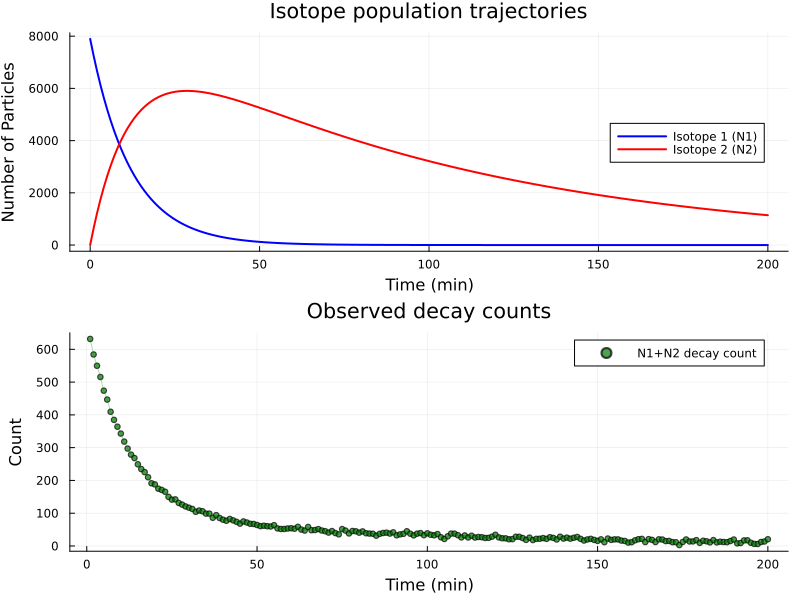

In [12]:
time_full = 0:dt:(T*dt)
time_obs = dt:dt:(T*dt)

# Population trajectories
p1 = plot(time_full, N1_trajectory, 
    label="Isotope 1 (N1)", lw=2, color=:blue,
    xlabel="Time (min)", ylabel="Number of Particles",
    title="Isotope population trajectories",
    legend=:right)
plot!(p1, time_full, N2_trajectory, label="Isotope 2 (N2)", lw=2, color=:red)

# Observed decay counts
p2 = scatter(time_obs, observations, 
    label="N1+N2 decay count", ms=3, alpha=0.7, color=:green,
    xlabel="Time (min)", ylabel="Count",
    title="Observed decay counts")
plot!(p2, time_obs, observations, alpha=0.3, color=:green, label="")

plot(p1, p2, layout=(2,1), size=(800, 600))